## Outline

* Downloading dataset (CIFAR10)
* `Dataloader` in `torch.utils`
* Visualising images
* Single and multiple convolutional layers
* LeNet
* Training LeNet
* Training on GPU
* Simple visualisation
* Exercises

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

## Data loading

In [2]:
# Used for loding datasets
import torchvision
import torchvision.transforms as transforms

#torchvision.datasets.CIFAR10 tells wehre to download it from, root tells the location of where to store,
# download=True tells to download it localy and not work with it remotely, 
# transforms will apply some transformation function when we are downloading the data itself(Here we are transforming them to tensors)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

# CIFAR10 dataset - https://www.cs.toronto.edu/~kriz/cifar.html. It has 60000 32X32 coloured images. 
# The images are classified into 3 classes 
# They are divided into 5 training batches, each containing 10000 images, and there is a test batch

Files already downloaded and verified


In [3]:
# These are the classes as mentioned and declared by us, obiously the dataset will have these lables already. 
# The name of the classes may differ on what I have defined here and the original lables
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# As we now have the dataset loaded into the variable trainset, we can now load data from it in certain batch size, 
# shuffle true means 4 images will be given randomly
# We are not loding it just now this is just the datastructure ready
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [5]:
# To access the trainloader variable dataset we created, 
# the way to do that is to create an itereator using 'iter' and storing it into variable dataiter
dataiter = iter(trainloader)
# dataiter.next() give one instance of 4 images and thier corrsponding lable from the dataset, which we have stored in the variable 'images' and 'lable'
images, labels = dataiter.next()

print(images.shape)
# The output [4, 3, 32, 32] says the batch size is 4, 3 channels RGB, 32 X 32 size image

print(images[0].shape)
# This shows that the the 2nd item has 3 channels of size 32X32
print(labels[0].item())
# This shows the label as in here it shows 3 which corresponds to 'cat'

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
9


## Visualise data

In [6]:
img = images[0]
print(type(img))

<class 'torch.Tensor'>


In [7]:
# Converting tensor into numpy
npimg = img.numpy()
print(npimg.shape)

(3, 32, 32)


In [8]:
# For a higher dimentional matrix transpose means any permutation of the different axis
# We are doing this because we need it in the order of x,y,z where z corresponds to the 3 channels RGB
npimg = np.transpose(npimg, (1, 2, 0)) # So the first index is 1st - 32 2nd - 32 3rd - 3
print(npimg.shape)

(32, 32, 3)


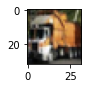

In [9]:
plt.figure(figsize = (1,1))
# imshow is image plotting in matplotlib
plt.imshow(npimg)
plt.show()
# As we can see the lable 0 corresponded to class 9 which was a truck, and the image is of a truck.

In [10]:
# This funciton does all of what the above lines does i.e.
# takinga given tensor, converting it to numpy, transposing it and then plotting it
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

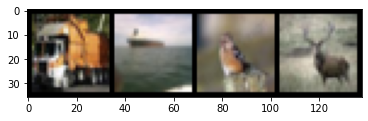

truck ship bird deer


In [11]:
# We are using the utils of torchvision some variable called make grid and we give them the images tensor that we created in the last cell of data loding
# We give that to the imshow function and we get a grid of images   
imshow(torchvision.utils.make_grid(images))
# We are also printing the corresponding classes to the images
print(' '.join(classes[labels[j]] for j in range(4)))   

## Single Convolutional Layer

In [12]:
# here we are just taking inputs (images in this case) have a single convolution layer and come out with a output
# mimporting torch.nn library
import torch.nn as nn
# We use nn.Module from which our class inherits, we saw this in the Intro to PyTorch
class FirstCNN(nn.Module):
    def __init__(self): 
        # init of the parent class
        super(FirstCNN, self).__init__()
        # Althouh the tenson in our case is 4D (batch, channels RGB,2 more dimention of X and Y size),
        # The convolution operation that we are applying is 2D, because the kernal tranlated in 2D (studied in theory)
        # nn.Conv2d first takes the no. of channels(input channle), second takes the no of output channels, third kernal of size 3
        self.conv1 = nn.Conv2d(3, 16, 3, padding=(1,1), stride=(2,2)) # padding=(1,1), stride=(2,2))
        # 16 different kernals are going through the image and output one channel each

    # Then defining the forward pass, taking x an input
    def forward(self, x):
        # on the given inpu we are applying conv1 function we defined above and return the value
        x = self.conv1(x)
        return x

In [13]:
# Instantiation
net = FirstCNN()

In [14]:
out = net(images)
out.shape
# shape of the output
# [4,16,16,16] here 4 corresponds to the back size , 16 corresponds to the number of output channels then the image size, 
# the next16 and 16 corresponds to 

torch.Size([4, 16, 16, 16])

In [15]:
# There are a bunch of parameter which are automatically created when we do nn.conv2D
for param in net.parameters():
    print(param.shape)

# We have 16 kernals, each of size 3 (channel size), the next 3,3 is the kernal size these are the weights
# The the second one is the bias

torch.Size([16, 3, 3, 3])
torch.Size([16])


In [16]:
# We are taking one channel of the 16x16
# For the 0th batch, 0th channel (out of the give 16), all the 16 * 16 values (detach to make numpy array)
out1 = out[0, 0, :, :].detach().numpy()
print(out1.shape)

(16, 16)


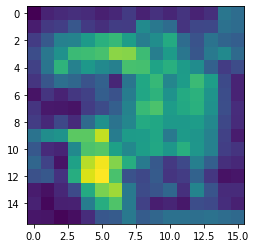

In [17]:
# plotting the detached numpy array
plt.imshow(out[0, 0, :, :].detach().numpy())
plt.show()

Question  
What are the dimensions of the output obtained when applying nn.Conv2d(3, 23, 5, padding=(1,1), stride=(2,2)) to any CIFAR10 image  
(23,15,15)

## Deep Convolutional Network

In [18]:
class FirstCNN_v2(nn.Module):
    def __init__(self): 
        super(FirstCNN_v2, self).__init__()
        # We are using sequential here in which we can stack up multiple transforms
        self.model = nn.Sequential(
            #3 input channels, 8 output channels, 3*3 kernal
            nn.Conv2d(3, 8, 3),   # (N, 3, 32, 32) -> (N, 8, 30, 30)
            # As we have 8 as an output of the first transform, hence input will have 8 channels, 
            # 16 output channels and 3*3 kernal
            nn.Conv2d(8, 16, 3)   # (N, 8, 30, 30) -> (N, 16, 28, 28)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [19]:
net = FirstCNN_v2()
out = net(images)
out.shape

torch.Size([4, 16, 28, 28])

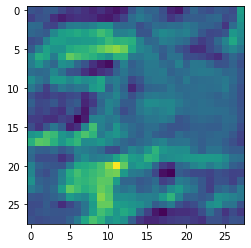

In [20]:
plt.imshow(out[0, 0, :, :].detach().numpy())

In [21]:
# Adding some additional layers like average pooling
class FirstCNN_v3(nn.Module):
    def __init__(self): 
        super(FirstCNN_v3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),          # (N, 3, 32, 32) -> (N, 6, 28, 28)
            # Taking batches in 2D, first paramerter corresponds to what size batches are we looking at size 2, and then stride of 2 so that they do not overlap
            nn.AvgPool2d(2, stride=2),   # (N, 6, 28, 28) -> (N, 6, 14, 14)
            nn.Conv2d(6, 16, 5),         # (N, 6, 14, 14) -> (N, 16, 10, 10)
            nn.AvgPool2d(2, stride=2)    # (N, 16, 10, 10) -> (N, 16, 5, 5)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
net = FirstCNN_v3()
out = net(images)
out.shape

torch.Size([4, 16, 5, 5])

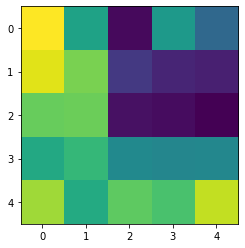

In [23]:
plt.imshow(out[0, 0, :, :].detach().numpy())
# As it is just 5 x 5 here it is difficult to see what is happening

## LeNet

In [24]:
# To understand in a bettre way see the pdf page 22
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        # First building the CNN part of the network
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28) the size decreases because we are using akernal of 5 x 5
            nn.Tanh(),                  # Adding a non linearity
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        # We are building the second set of sequentials (The linear fully connected one)
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120) 400 because 16*5*5
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10) # last layer
        )
        
    def forward(self, x):
        print(x.shape)
        # We will apply the first cnn_model to the given input
        x = self.cnn_model(x)
        print(x.shape)
        # Flattening of the tensors - first index corresponds to the batch (so we are going to keep the dimentions)
        # Everythong else is collapsed into the second index
        x = x.view(x.size(0), -1)
        print(x.shape)
        # After respahing we are goint to pass them through the fc_model
        x = self.fc_model(x)
        print(x.shape)
        # Output that we recieved after applying the LeNet Model
        return x

In [25]:
net = LeNet()
out = net(images)

torch.Size([4, 3, 32, 32])
torch.Size([4, 16, 5, 5])
torch.Size([4, 400])
torch.Size([4, 10])


In [26]:
print(out)

tensor([[ 0.0194,  0.0178,  0.0688, -0.0951,  0.0735,  0.1062, -0.0674,  0.0184,
          0.0509, -0.1179],
        [ 0.0186,  0.0089,  0.0633, -0.0986,  0.0707,  0.1206, -0.0768,  0.0120,
          0.0438, -0.1217],
        [ 0.0170,  0.0131,  0.0730, -0.0944,  0.0819,  0.1195, -0.0793,  0.0106,
          0.0473, -0.1152],
        [ 0.0162,  0.0237,  0.0775, -0.0966,  0.0873,  0.1127, -0.0641,  0.0194,
          0.0584, -0.1150]], grad_fn=<AddmmBackward>)


In [27]:
max_values, pred_class = torch.max(out.data, 1)
print(pred_class)

tensor([5, 5, 5, 5])


## Training LeNet

In [28]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [29]:
# Loding the data with a higher barch size
# Uisng a power of 2 because it is sometimes more effecient to use them in GPU's
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
# Defining the batchs ize here 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
# Given a particular loader it computes the accuracy of the model
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        # laving the data components in 2 parts, these are the ground truths
        inputs, labels = data
        # We are applying the LeNet in the uptput we get the N, 10 tensor
        outputs = net(inputs)
        # computing the predicted values using torch.max 
        _, pred = torch.max(outputs.data, 1)
        # Keeping track of the total no we have seen, and the once that are correct
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    # Finally returning the percentage of accurate predictions
    return 100 * correct / total



In [31]:
net = LeNet()

In [32]:
# Backpropagation
import torch.optim as optim
# Using cross entropy loss function
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

Epoch: 0/16, Test acc: 38.95, Train acc: 39.10
Epoch: 1/16, Test acc: 43.43, Train acc: 44.18
Epoch: 2/16, Test acc: 47.03, Train acc: 47.67
Epoch: 3/16, Test acc: 49.28, Train acc: 50.43
Epoch: 4/16, Test acc: 50.22, Train acc: 52.41
Epoch: 5/16, Test acc: 52.30, Train acc: 55.05
Epoch: 6/16, Test acc: 53.63, Train acc: 56.97
Epoch: 7/16, Test acc: 54.32, Train acc: 58.18
Epoch: 8/16, Test acc: 54.95, Train acc: 59.20
Epoch: 9/16, Test acc: 55.30, Train acc: 60.55
Epoch: 10/16, Test acc: 55.83, Train acc: 61.32
Epoch: 11/16, Test acc: 55.60, Train acc: 62.52
Epoch: 12/16, Test acc: 56.48, Train acc: 63.31
Epoch: 13/16, Test acc: 56.34, Train acc: 63.67
Epoch: 14/16, Test acc: 56.83, Train acc: 65.01
Epoch: 15/16, Test acc: 56.65, Train acc: 65.71


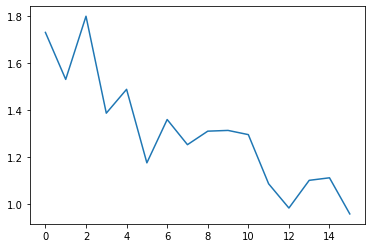

Wall time: 10min 33s


In [33]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in range(max_epochs):
    # Each time we will iterate through the training loader, set the inputs and labels
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        # To reset any previous gradients on them
        opt.zero_grad()

        #forward pass
        outputs = net(inputs)
        # Loss  computation
        loss = loss_fn(outputs, labels)
        # backpropagation
        loss.backward()
        # step wherein we update all the parameters
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

## Move to GPU

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [35]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        # Wehen we are moving the data to variables we have to declare that they are going to GPU uinsg inputs.to(device)
        inputs, labels = inputs.to(device), labels.to(device)
        # We moved input and output to GPU becasue we have to move the net (the netowrk) to the GPU
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [36]:
# Moving the net to GPU
net = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

In [37]:
%%time
# Training Loop
max_epochs = 16

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
    print('Epoch: %d/%d' % (epoch, max_epochs))

Epoch: 0/16
Epoch: 1/16
Epoch: 2/16
Epoch: 3/16
Epoch: 4/16
Epoch: 5/16
Epoch: 6/16
Epoch: 7/16
Epoch: 8/16
Epoch: 9/16
Epoch: 10/16
Epoch: 11/16
Epoch: 12/16
Epoch: 13/16
Epoch: 14/16
Epoch: 15/16
Wall time: 4min 57s


In [38]:
# Printing the accuracy on test and train
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(testloader), evaluation(trainloader)))

Test acc: 55.63, Train acc: 64.96


NOTE  
Important thing is to ensure that the net, the input the output all are in the GPU.

## Basic Visualisation

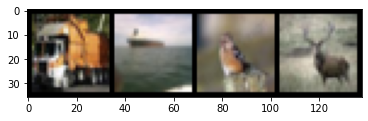

In [39]:
imshow(torchvision.utils.make_grid(images))

In [40]:
# Since the images are in the CPU we are going to move the net to CPU
net = net.to('cpu')

In [41]:
out = net(images)
print(out.shape)

torch.Size([4, 10])


In [42]:
# We want to see the output of the first covolution layer. 
# We will have different sequential models we would have declared 
# So inside the different squential models there are different layers, in which we want to see the output of the layer
out = net.cnn_model[0](images) # Here we are siing the first layer
out.shape

torch.Size([4, 6, 28, 28])

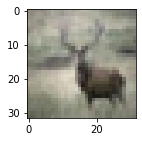

In [43]:
# Taking one particular image
image_id = 3
plt.figure(figsize = (2,2))
imshow(images[image_id,])

<ipython-input-44-8ecf16ba7bcc>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(3, 2, i+1)


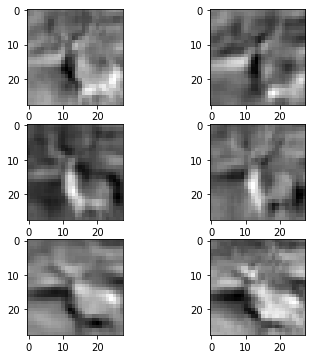

In [44]:
# So fot this particular image we would like to print all the particular 6 layers
plt.figure(figsize = (6,6))
plt.subplot(321)
for i in range(6):
    ax1 = plt.subplot(3, 2, i+1)
    plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap="binary")
plt.show()

## Exercises

* Modify LeNet to work with ReLU instead of Tanh -> What is the impact on training time, final loss
* We have observed over-fitting -> Use weight_decay in torch.optim to add L2 regularisation
* Instead of CIFAR10, use the MNIST data available from `torchvision.datasets.MNIST`. Download and visualise MNIST data.
* But importantly MNIST images have only 1 channel instead of 3 channels in the case of CIFAR10. Modify LeNet to work with MNIST. Train and find optimised test accuracy.